# Predicting Compound Mechanism of Action (MOA): Improving the Accuracy

This notebook will be lots of messing around with various data transformation techniques and machine learning tools to try and improve the accuracy at classifying mechanism of action (MOA) from morhpological features of cells *in vitro*.

In [6]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
import sklearn
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("bmh")

# check library versions
print("sklearn version\t", sklearn.__version__)
print("pandas version\t", pd.__version__)
print("numpy version\t", np.__version__)

url = "https://dl.dropboxusercontent.com/u/79810285/df_cell_subclass.csv"
df = pd.read_csv(url)
# remove DMSO values
df = df[df.Metadata_compound != "DMSO"]

sklearn version	 0.17.1
pandas version	 0.17.1
numpy version	 1.10.1


For this classification task we will use all the data of the eight cell lines pooled together, though will remove the lower concentrations of compounds

In [7]:
df_h_conc = df[df.Metadata_concentration >= 100]

Now split the data into two arrays:
1. Numerical featuredata
2. MOA labels as integers

In [8]:
# MOA and integer codes
moa_names = df_h_conc.Metadata_compoundClass
moa_int = pd.Categorical(moa_names).codes

# featuredata as an array
feature_cols = [col for col in df_h_conc.columns if not col.startswith("Metadata")]
feature_array = np.array(df_h_conc[feature_cols])

## Naive Classification Accuracy

First we will set a benchmark of classification accuracy by using a random forest classifier with mainly default parameters on the normalised data.

In [13]:
N_ITERATIONS = 100
acc_out = []

for i in range(0, N_ITERATIONS):
    # split into training and test datasets
    x_train, x_test, y_train, y_test = train_test_split(
        feature_array, moa_int,
        test_size=0.33)
    
    # create random forest model
    clf = ensemble.RandomForestClassifier(n_jobs=-1)
    # train model on training data
    clf.fit(x_train, y_train)
    # predict MOA classes from test data
    predictions = clf.predict(x_test)
    # determine percentage accuracy of predictions
    perc_correct = clf.score(x_test, y_test) * 100
    acc_out.append(perc_correct)
    
print("Naive MOA classification accuracy = %.1f" %np.mean(acc_out), "%")

Naive MOA classification accuracy = 64.0 %


## Does standardising the data improve naive classification score?

Our data is already normalised individually for each feature, although we can normalise the entire array to have a mean of 0 and unit variance.

In [14]:
norm_array = preprocessing.scale(feature_array)

N_ITERATIONS = 100
acc_out = []

for i in range(0, N_ITERATIONS):
    # split into training and test datasets
    x_train, x_test, y_train, y_test = train_test_split(
        norm_array, moa_int,
        test_size=0.33)
    
    # create random forest model
    clf = ensemble.RandomForestClassifier(n_jobs=-1)
    # train model on training data
    clf.fit(x_train, y_train)
    # predict MOA classes from test data
    predictions = clf.predict(x_test)
    # determine percentage accuracy of predictions
    perc_correct = clf.score(x_test, y_test) * 100
    acc_out.append(perc_correct)
    
print("Pre-processed data MOA classification accuracy = %.1f" %np.mean(acc_out), "%")

Pre-processed data MOA classification accuracy = 64.3 %


We get a very small increase in classification accuracy by scaling the entire dataset.

## At what point does increasing model complexity no longer increase prediction accuracy?

More decision trees in a forest increases classification accuracy, but increases computation time. At a certain point the accuracy levels off. So we should determine the optimum number of estimators to use for this dataset. We can find this out by out-of-bag (OOB) error for each number of estimators, and determine the minimum value of `n_estimators` at which the error stabilises.

In [15]:
min_estimators = 10
max_estimators = 1000

# split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    norm_array, moa_int, test_size=0.33)
# create model
clf = ensemble.RandomForestClassifier(warm_start=True)
errors = []
# fit models with increasing n_estimators
for i in range(min_estimators, max_estimators+1):
    clf.set_params(n_estimators=i, oob_score=True, n_jobs=-1)
    clf.fit(x_train, y_train)
    # extract OOB error rate
    oob_error = 1 - clf.oob_score_
    errors.append(oob_error)

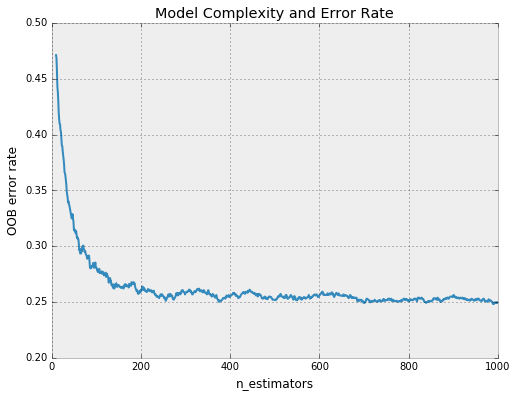

In [16]:
# plot error against n_estimators
plt.figure(figsize=(8,6))
plt.plot(range(min_estimators, max_estimators+1), errors)
plt.title("Model Complexity and Error Rate")
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

So it looks like ~600 decision trees (`n_estimators`) is the point at which the error rate stabilises - which is quite a complicated model.

## MOA classification with 600 decision trees

In [19]:
x_train, x_test, y_train, y_test = train_test_split(
    norm_array, moa_int, test_size=0.33)
clf = ensemble.RandomForestClassifier(n_estimators=650, n_jobs=-1)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
perc_correct = clf.score(x_test, y_test) * 100
print("MOA prediction accuracy with 600 trees = %.1f" %perc_correct, "%")

MOA prediction accuracy with 600 trees = 74.4 %


### Bootstrapping to get a more stable measure of accuracy

Both the random forest and the data split to get test and training sets are random. This means that the accuracy of the above results changes every time you re-run it. To get a more stable accuracy measure you can run the model and data split many times and find the average value.

In [20]:
n_repeats = range(0, 10)
accuracy_out = []
for i in n_repeats:
    x_train, x_test, y_train, y_test = train_test_split(
    feature_array, moa_int, test_size=0.33)
    clf = ensemble.RandomForestClassifier(n_estimators=650,
                                          n_jobs=-1,
                                          max_features=0.8)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    correct = predictions == y_test
    perc_correct = sum(correct) / len(correct) * 100
    accuracy_out.append(perc_correct)
    
print("Average bootstrapped prediction accuracy %.1f"
      %np.mean(accuracy_out), "%")

Average bootstrapped prediction accuracy 77.2 %


## Does using AdaBoost improve prediction accuracy?

Try the AdaBoost (**Ada**ptive **Boost**ing) method which wraps any ensemble classification task to try and improve their performance. Essentially combines lots of weak learners, and as long as their classification accuracy is better than random guessing then they contribute to prediction accuracy.

In [24]:
n_repeats = range(0, 10)
accuracy_out = []

for i in n_repeats:
    x_train, x_test, y_train, y_test = train_test_split(
        feature_array, moa_int, test_size=0.33)
    clf = ensemble.AdaBoostClassifier(
        ensemble.RandomForestClassifier(
            n_estimators=600,
            n_jobs=-1,
            max_features=0.8))
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    correct = predictions == y_test
    perc_correct = sum(correct) / len(correct) * 100
    accuracy_out.append(perc_correct)
    
av_accuracy = np.mean(accuracy_out)
print("AdaBoost prediction accuracy = %.1f"
     %av_accuracy, "%")

AdaBoost prediction accuracy = 75.8 %


We see that the AdaBoost method does not necessarily improve the accuracy, and in some cases actually decreases it.

## How about gradient boosted trees?

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    feature_array, moa_int, test_size=0.33)

clf = ensemble.GradientBoostingClassifier(n_estimators=1000)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
accuracy = clf.score(x_test, y_test) * 100
print("Gradient boosting MOA accuracy = %.1f"
     %accuracy, "%")

Gradient boosting MOA accuracy = 83.1 %


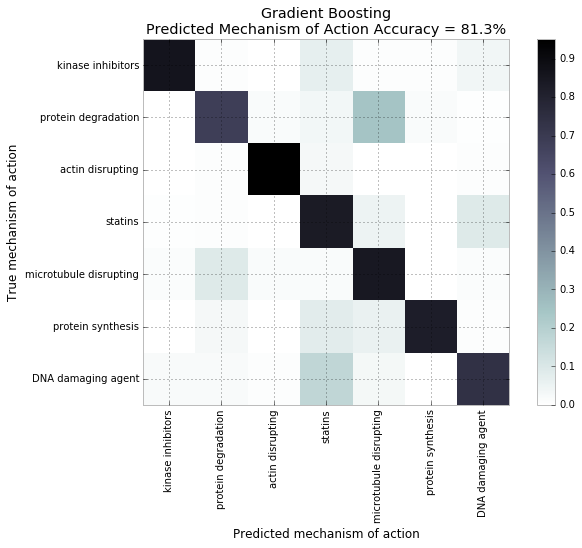

In [129]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
# normalise confusion matrix for diff sized groups
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Gradient Boosting"
    "\nPredicted Mechanism of Action Accuracy = {0:.1f}%".format(accuracy))
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(set(moa_names)))
plt.xticks(tick_marks, set(moa_names), rotation = 90)
plt.yticks(tick_marks, set(moa_names))
plt.ylabel('True mechanism of action')
plt.xlabel('Predicted mechanism of action')
plt.show()

So using gradient boosted trees improves the classification by ~4%, though computation is much slower as we can't parallelise the training.

### Does increasing the number of estimators continue to increase classification accuracy in gradient boosted models?

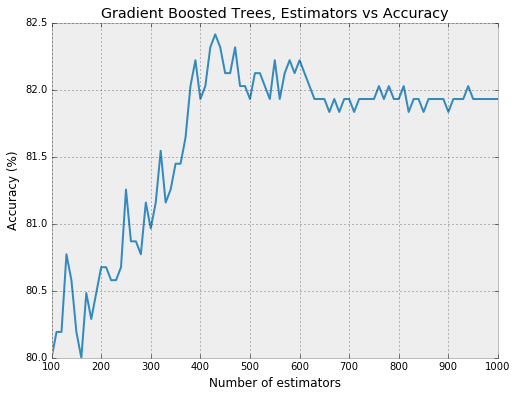

In [134]:
min_est = 100
max_est = 1000
estimator_range = np.arange(min_est, max_est+1, 10)
acc_out = []

x_train, x_test, y_train, y_test = train_test_split(
    feature_array, moa_int, test_size=0.33)

for i in estimator_range:
    clf = ensemble.GradientBoostingClassifier(
        n_estimators=i,
        warm_start=True)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    accuracy = clf.score(x_test, y_test) * 100
    acc_out.append(accuracy)
    
plt.figure(figsize=(8,6))
plt.plot(estimator_range, acc_out)
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy (%)")
plt.title("Gradient Boosted Trees, Estimators vs Accuracy")
Splt.show()

From this we can see accuracy levels of after 450 estimators, although even with 100 estimators the accuracy is still pretty high at 80%.

## How high can we get the accuracy of random forests by tuning all the parameters?

We have already optimised `n_estimators`, which determines the number of decision trees in the model, though there are still other parameters such as:

- `max_features`: Number of features to consider when looking for the best split
- `max_depth`: Limiting the maximum depth of a tree
- `min_samples_split`: The minumum number of samples required to split a node
- `min_samples_leaf`: The minumum samples in newly created leaves

### Max features

The default argument for `max_features` is to take the $\sqrt{\texttt{n_features}}$. We can try altering this to see if classification accuracy decreases with more features.

First attempt will use an increasing percentage of the number of features.

In [75]:
percs = np.arange(1, 100, 2)
x_train, x_test, y_train, y_test = train_test_split(
feature_array, moa_int, test_size=0.33)
clf = ensemble.RandomForestClassifier()
errors = []

# fit models with increasing percentage of max_features
for i in percs:
    clf.set_params(max_features=i, n_estimators=600, oob_score=True, n_jobs=-1)
    clf.fit(x_train, y_train)
    # extract OOB error rate
    oob_error = 1 - clf.oob_score_
    errors.append(oob_error)

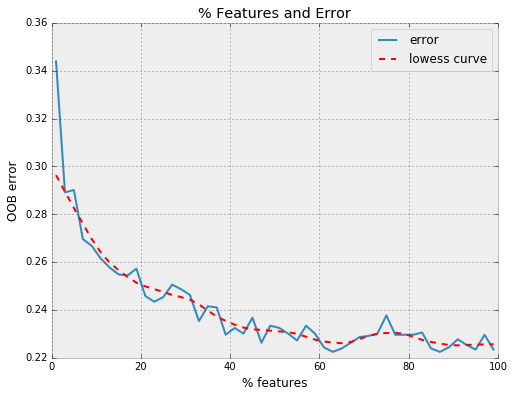

In [77]:
# fit a loess curve to the data
lowess = sm.nonparametric.lowess(errors, percs, frac=0.2)
# plot data and curve
plt.figure(figsize=(8,6))
plt.xlim((0, 100))
plt.plot(percs, errors, label="error")
plt.plot(lowess[:, 0], lowess[:, 1], "r--", label="lowess curve")
plt.xlabel("% features")
plt.ylabel("OOB error")
plt.title("% Features and Error")
plt.legend()
plt.show()

It looks like the error decreases with increasing number of features and stabilises ~80% of the features, which means that increasing the number of features does not start to decrease the error rate by adding noise.

### Error rate across increasing estimators with different feature counts

We determined the number of estimators using the default value for the number of features. It will be worth while to see if this error rate is affected by the number of features.

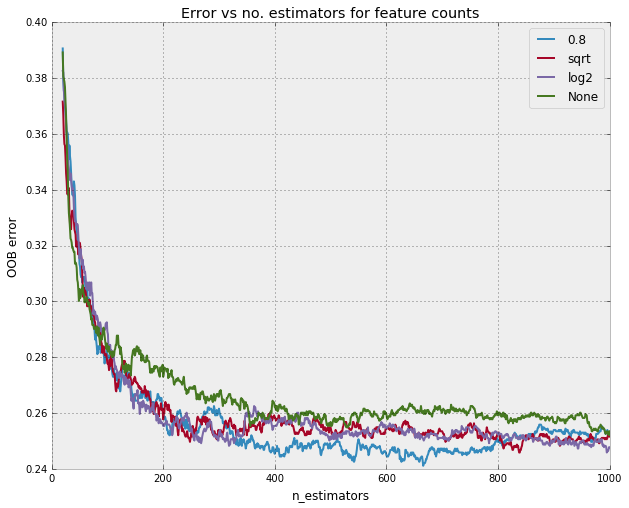

In [21]:
# determine the OOB error with increasing n_estimators with various classes
# of n_features, such as all the features, sqrt(n_features), log2(n_features)

min_estimators = 20
max_estimators = 1000
estimators = range(min_estimators, max_estimators+1)

# split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    feature_array, moa_int, test_size=0.33)

feature_settings = [0.8, "sqrt", "log2", None]
plt.figure(figsize=(10,8))

for f_set in feature_settings:
    # create model
    clf = ensemble.RandomForestClassifier(max_features=f_set,
                                          warm_start=True)
    errors = []
    
    # fit models with increasing n_estimators
    for i in estimators:
        clf.set_params(n_estimators=i, oob_score=True, n_jobs=-1)
        clf.fit(x_train, y_train)
        # extract OOB error rate
        oob_error = 1 - clf.oob_score_
        errors.append(oob_error)
        
    plt.plot(estimators,
             errors,
             label=str(f_set))

plt.xlabel("n_estimators")
plt.ylabel("OOB error")
plt.title("Error vs no. estimators for feature counts")
plt.legend(title="max_features")
plt.show()

So there's not a huge difference between the feature choice for each set.

# Feature engineering

Rather than altering the model, we might be able to improve predictions by altering the features. This can be done by feature selection, feature transformation (i.e PCA) or feature normalisation such as generalised log.

### Principal component analysis

First, we will try to transform our features into principal components and pass that to our random forest model, and see how that effects our prediction accuracy. We will try extracting various principal components and also try whitening to remove linear correlation between features.

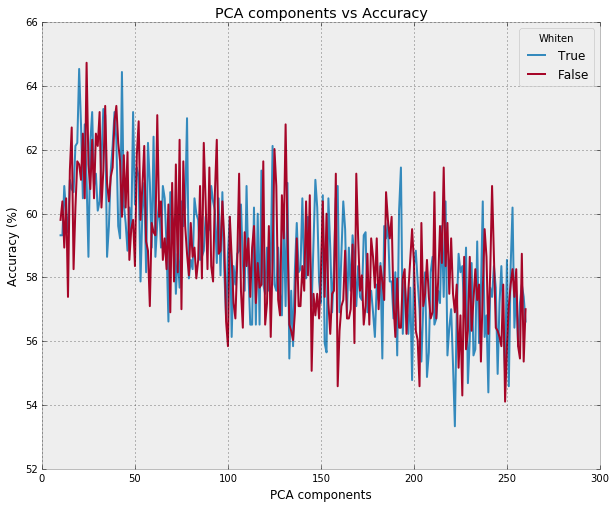

In [23]:
from sklearn.decomposition import PCA

# range of principal components from 10 -> n_columns in featuredata
ncol = feature_array.shape[1]
pca_comps = range(10, ncol+1)

# we will try with and without whitening
whiten_opts = [True, False]

plt.figure(figsize=(10,8))

for opt in whiten_opts:
    
    pca_acc = []
    
    for i in pca_comps:
        # PCA
        pca = PCA(n_components=i, whiten=opt)
        pca_array = pca.fit_transform(feature_array)
        # data split: train, test
        x_train, x_test, y_train, y_test = train_test_split(
            pca_array, moa_int, test_size=0.33)
        # train random forest model
        clf = ensemble.RandomForestClassifier(max_features=0.8,
                                             n_estimators=650,
                                             n_jobs=-1)
        clf.fit(x_train, y_train)
        # determine prediction accuracy
        predictions = clf.predict(x_test)
        correct = predictions == y_test
        perc_correct = sum(correct) / len(correct) * 100
        pca_acc.append(perc_correct)
    
    plt.plot(pca_comps, pca_acc, label=str(opt))
    
plt.legend(title="Whiten")
plt.title("PCA components vs Accuracy")
plt.xlabel("PCA components")
plt.ylabel("Accuracy (%)")
plt.show()

So increasing the number of principal components used in the random forest actually *decreases* the accuracy of MOA prediction, and whitening the data does not appear to influence accuracy.

### PCA and whitening data before boosted trees

Does whitening the data before boosted trees improve classification accuracy?

In [144]:
whiten_opts = [True, False]
results = dict()

for opt in whiten_opts:
    pca = PCA(n_components=45, whiten=opt)
    pca_array = pca.fit_transform(feature_array)
    x_train, x_test, y_train, y_test = train_test_split(pca_array,
                                                   moa_int,
                                                   test_size=0.33)
    clf = ensemble.GradientBoostingClassifier(n_estimators=500)
    clf.fit(x_train, y_train)
    clf.predict(x_test)
    acc = clf.score(x_test, y_test) * 100
    results[str(opt)] = acc

In [146]:
results

{'False': 61.835748792270529, 'True': 62.705314009661841}

Whitening produces a very small increase in the accuracy, though this may not be statistically significant.